In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import datetime
import numpy as np
from utils_2D import Q, rmsre

In [2]:
# set precision (default is 'float32')
K.set_floatx('float64')

In [ ]:
def load_data(fname):

    data = np.load(fname, allow_pickle=True)

    feq   = data['f_eq']
    fpre  = data['f_pre']
    fpost = data['f_post']
    
    return feq, fpre, fpost

def LBrot90(f, k=1):   
    return tf.concat( [ f[:,0,None], tf.roll(f[:,1:5], k, axis=-1),  
                                     tf.roll(f[:,5: ], k, axis=-1) 
                      ], axis=-1 )

def LBmirror(f):
    return tf.concat( [f[:,0, None],
                       f[:,1, None], f[:,4, None], 
                       f[:,3, None], f[:,2, None], f[:,8, None], 
                       f[:,7, None], f[:,6, None], f[:,5, None]
                       ], axis=-1 )

class D4Symmetry(tf.keras.layers.Layer):
    def __init__(self):
        super(D4Symmetry, self).__init__()

    def call(self, x):

        y = [x               ,
             LBrot90(x, k=1 ),
             LBrot90(x, k=2 ),
             LBrot90(x, k=3 ),
             LBmirror(x               ),
             LBmirror(LBrot90(x, k=1 )),
             LBmirror(LBrot90(x, k=2 )),
             LBmirror(LBrot90(x, k=3 ))]
        
        return y


class D4AntiSymmetry(tf.keras.layers.Layer):
    def __init__(self):
        super(D4AntiSymmetry, self).__init__()

    def call(self, x):

        y = [x[0],
             LBrot90(x[1], k=-1 ),
             LBrot90(x[2], k=-2 ),
             LBrot90(x[3], k=-3 ),
             LBmirror(x[4])                ,
             LBrot90(LBmirror(x[5]), k=-1 ),
             LBrot90(LBmirror(x[6]), k=-2 ),
             LBrot90(LBmirror(x[7]), k=-3 )]
        
        return y
    
    
class AlgReconstruction(tf.keras.layers.Layer):
    def __init__(self):
        super(AlgReconstruction, self).__init__()

    def call(self, fpre, fpred):

        df  = fpred - fpre

        df2 =       -(df[:,0]+2*df[:,3]+  df[:,4]+2*df[:,6]+2*df[:,7])
        df5 =    0.5*(df[:,0]+3*df[:,3]+2*df[:,4]+2*df[:,6]+4*df[:,7]-df[:,1])
        df8 =   -0.5*(df[:,0]+  df[:,1]+  df[:,3]+2*df[:,4]+2*df[:,7])
        
        df = tf.concat( [ df[:, 0, None],
                          df[:, 1, None],
                          df2[:,None],
                          df[:, 3, None],
                          df[:, 4, None],
                          df5[:,None],
                          df[:, 6, None],
                          df[:, 7, None],
                          df8[:,None]
                        ], axis=-1 ) 

        res = fpre + df

        return res    
    
    
# class AlgReconstructionSymm(tf.keras.layers.Layer):
#     def __init__(self):
#         super(AlgReconstructionSymm, self).__init__()

#     def call(self, fpre, fpred, c):

#         df  = fpred - fpre

#         df_sum = tf.reduce_sum( df, axis=1 )
        
#         k1 = - (1./9.)*df_sum
#         k2 = - (1./6.)*(tf.reduce_sum( df*c[:,0], axis=1 ) )
#         k3 = - (1./6.)*(tf.reduce_sum( df*c[:,1], axis=1 ) )
        
#         res = fpred + k1[:,None] + k2[:,None]*c[:,0] + k3[:,None]*c[:,1]

#         return res
    

In [4]:
def sequential_model(Q=9, n_hidden_layers=2, n_per_layer=50, activation="relu", 
                     ll_activation="linear", bias=False):
    
    model = Sequential()
    
    model.add(Dense(n_per_layer, input_shape=(Q,), activation=activation, use_bias=bias, kernel_initializer = "he_uniform"))
    
    for jj in range(n_hidden_layers):
        model.add(Dense(n_per_layer, activation=activation, use_bias=bias, kernel_initializer = "he_uniform"))
    
    model.add(Dense(Q, activation=ll_activation, use_bias=bias, kernel_initializer = "he_uniform"))

    return model 

def create_model(loss="mape", optimizer="adam", Q=9, 
                 n_hidden_layers=2, n_per_layer=50, activation="relu", 
                 ll_activation="linear", bias=False):
    
    the_input = keras.Input(shape=(Q,))

    seq_model = sequential_model(Q, n_hidden_layers, n_per_layer, 
                                 ll_activation, ll_activation, bias)
    
    input_lst  = D4Symmetry()(the_input)
    
    output_lst = [seq_model(x) for k, x in enumerate(input_lst) ]

    output_lst = [AlgReconstruction()(input_lst[k], x) for k, x in enumerate(output_lst) ] 
    # output_lst = [AlgReconstructionSymm()(input_lst[k], x, c) for k, x in enumerate(output_lst) ] 

    output_lst = D4AntiSymmetry()(output_lst)
    
    the_output = layers.Average()(output_lst)

    model = keras.Model(inputs=the_input, outputs=the_output)
    
    model.compile(loss=loss, optimizer=optimizer)    
    
    return(model) 

In [5]:
###########################################################
# lattice velocities and weights
# Needed if you want to use AlgReconstructionSymm
# c, _, _, _ = LB_stencil()
# c = np.array(c, dtype=float)

In [6]:
# read training dataset
feq, fpre, fpost = load_data('example_dataset_2D.npz')

# normalize data on density 
feq   = feq   / np.sum(feq,axis=1)[:,np.newaxis]
fpre  = fpre  / np.sum(fpre,axis=1)[:,np.newaxis]
fpost = fpost / np.sum(fpost,axis=1)[:,np.newaxis]

# split train and test set
fpre_train, fpre_test, fpost_train, fpost_test = train_test_split(fpre, fpost, test_size=0.3, shuffle=True)

In [7]:
batch_size=32
n_epochs=200
patience=50
verbose=1

model = create_model(loss=rmsre, ll_activation="softmax")

# EarlyStopping
es_callback = [EarlyStopping(monitor = "val_loss", patience = patience, restore_best_weights=True)]

# Save weights on file when improving the validation loss
ck_callback = ModelCheckpoint(filepath="weights_2D.keras", monitor = "val_loss", save_best_only=True)

keras_callbacks = [es_callback, ck_callback]

## training the model
hist = model.fit(fpre_train, fpost_train, 
                 epochs=n_epochs, verbose=verbose, callbacks=keras_callbacks, 
                 validation_data = (fpre_test, fpost_test), batch_size=batch_size)

Epoch 1/200


/Users/owner/Projects/venv/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.3482 - val_loss: 0.0213
Epoch 2/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0212 - val_loss: 0.0213
Epoch 3/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0212 - val_loss: 0.0213
Epoch 4/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0212 - val_loss: 0.0211
Epoch 5/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0052 - val_loss: 4.7529e-04
Epoch 6/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.0301e-04 - val_loss: 3.8093e-04
Epoch 7/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.8412e-04 - val_loss: 3.5299e-04
Epoch 8/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.5454e-04 - val_loss: 3.8293e-04
Epoch 9/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.3954e-04 - val_loss: 3.2963e-04
Epoch 10/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.1462e-04 - val_loss: 2.5309e-04
Epoch 11/200
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.9649e-04 - 

In [8]:
model.load_weights("weights_2D.keras")
model.save("example_network_2D.keras")

In [9]:
model.evaluate(fpre_test, fpost_test)

938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step - loss: 6.6846e-05


6.684568189329776e-05

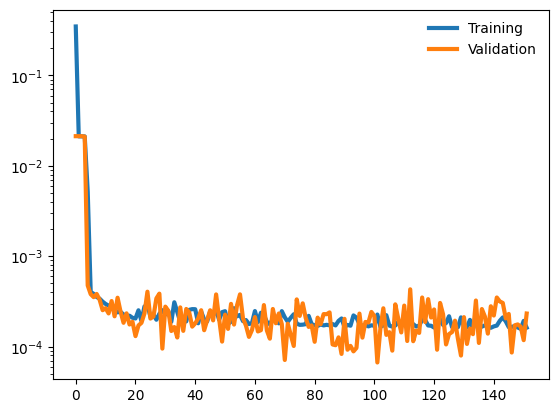

In [10]:
import matplotlib.pyplot as plt

plt.semilogy( hist.history['loss']    , lw=3, label='Training'   )
plt.semilogy( hist.history['val_loss'], lw=3, label='Validation' )

plt.legend(loc='best', frameon=False)

plt.show()